In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using BAT
using Distributions 
using IntervalSets

using HCubature

using Plots
using Colors
using ColorSchemes
using LaTeXStrings

pyplot(size=(750,500))

Plots.PyPlotBackend()

# Gamma Distribution Example: 

In [34]:
density_f(x; λ=1.5) =  pdf(Gamma(λ), x...)

density_f (generic function with 1 method)

In [35]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[-100.0 .. 100.0] )

Norm_prior = 200

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 2 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 6 chains, 3 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 6 chains, 5 tuned, 6 converged.
└ @ BAT /home/iwsat

In [36]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 100)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [37]:
function generate_hm_data(posterior, x_range, norm_prior, density_f; n_samples=10^2, n_chains=3, n_trials=10)
    
    cuba_integrals = []
    hm_estimates = []
    hm_std = []
    
    for i_trial in 1:n_trials
        samples = bat_sample(posterior, (n_samples, n_chains), MetropolisHastings()).result
        samples_vector = flatview(unshaped.(samples.v))[1,:]
        samples_likelihoods = exp.(samples.logd) * norm_prior
        samples_weights = samples.weight
        
        for x in x_range
            mask = samples_vector .< x
            V_run = x - x_range[1]
            hmi_estimate = (sum(samples_weights[mask] * V_run)) /(sum(samples_weights[mask]./samples_likelihoods[mask])) 
            push!(hm_estimates, hmi_estimate)
            
            if i_trial == n_trials[end]
                push!(cuba_integrals, hcubature(density_f, [x_range[1]], [x])[1])
            end
        end
        
    end
    
    hm_estimates = reshape(hm_estimates, length(x_range), n_trials)
    return mean(hm_estimates, dims=2)[:,1], std(hm_estimates, dims=2)[:,1], cuba_integrals
end

generate_hm_data (generic function with 1 method)

In [38]:
x_range =  range(0.1, stop=13, length=40)

hm_estimates, hm_std, cuba_integrals = generate_hm_data(posterior, x_range, Norm_prior, density_f, n_trials=50);

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsat

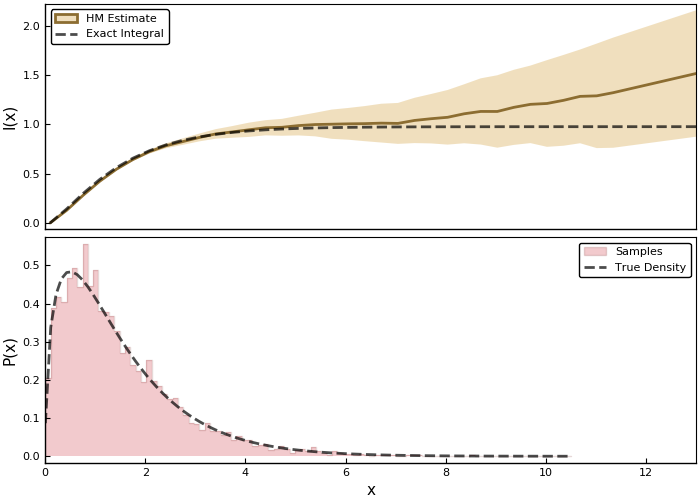

In [39]:
line_colors = ColorSchemes.tab20b

p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[13], 
        linealpha=0.2,
        fill=true, 
        fillcolor=line_colors[16],
        fillalpha=0.5, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(0.0, x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, hm_estimates, 
        lw=2, 
        linecolor=line_colors[9], 
        fillcolor=line_colors[12], 
        ribbon=hm_std,  
        fillalpha=0.6,  
        label="HM Estimate"
    )

p2 = plot!(x_range, cuba_integrals,  
        linestyle=:dash, 
        color=:black, 
        linealpha=0.7, 
        lw=2, 
        label="Exact Integral",
    )

p2 = plot!(legend=:topleft, 
        xlims=(0.0, x_range[end]),
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(p2, p1, layout = (2,1), size=(700,500))

# Normal Distribution Example: 

In [45]:
# Define target density function: 

# density_f(x; μ1=-1.5, μ2=1.5, σ=0.5) = (1/2)*(pdf(Normal(μ1, σ),x) + pdf(Normal(μ2, σ),x))

density_f(x; μ=0.0, σ=1) = 2*pdf(Normal(μ, σ),x...) 

density_f (generic function with 1 method)

In [46]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[0.0 .. 10.0] )

Norm_prior = 10

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 3 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 6 chains, 5 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 6 chains, 6 tuned, 6 converged.
└ @ BAT /home/iwsat

In [47]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 100)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [48]:
x_range =  range(0.0, stop=6, length=40)

hm_estimates, hm_std, cuba_integrals = generate_hm_data(posterior, x_range, Norm_prior, density_f, n_trials=50);

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 2 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 3 chains, 3 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 3 chains successful after 3 cycle(s).
└ @ BAT /home/iwsatlas1/vhaf

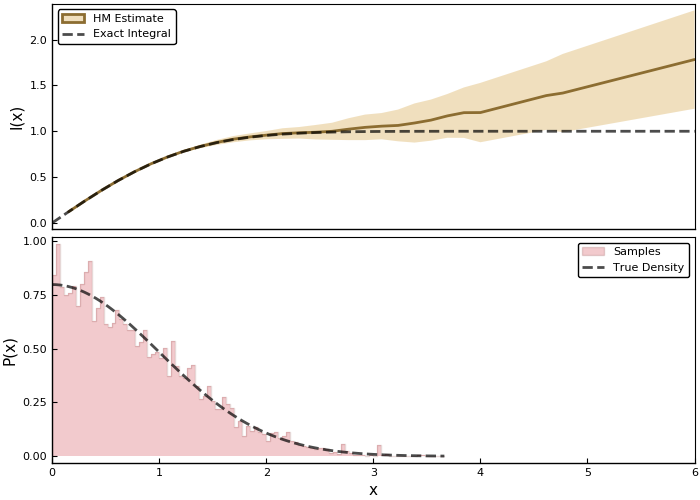

In [49]:
line_colors = ColorSchemes.tab20b

p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[13], 
        linealpha=0.2,
        fill=true, 
        fillcolor=line_colors[16],
        fillalpha=0.5, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(0.0, x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, hm_estimates, 
        lw=2, 
        linecolor=line_colors[9], 
        fillcolor=line_colors[12], 
        ribbon=hm_std,  
        fillalpha=0.6,  
        label="HM Estimate"
    )

p2 = plot!(x_range, cuba_integrals,  
        linestyle=:dash, 
        color=:black, 
        linealpha=0.7, 
        lw=2, 
        label="Exact Integral",
    )

p2 = plot!(legend=:topleft, 
        xlims=(0.0, x_range[end]),
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(p2, p1, layout = (2,1), size=(700,500))

# Normal Distribution Example: 

In [50]:
# Define target density function: 

# density_f(x; μ1=-1.5, μ2=1.5, σ=0.5) = (1/2)*(pdf(Normal(μ1, σ),x) + pdf(Normal(μ2, σ),x))

density_f(x; μ=0.0, σ=0.4) = pdf(Normal(μ, σ),x...) 

density_f (generic function with 1 method)

In [51]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[-10.0 .. 10.0] )

Norm_prior = 20

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x)))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^3
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 3 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 3 finished, 6 chains, 5 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 4 finished, 6 chains, 5 tuned, 6 converged.
└ @ BAT /home/iwsat

In [52]:
# Create histogram

samples_vector = flatview(unshaped.(samples.v))[1,:]
samples_likelihoods = exp.(samples.logd) * Norm_prior
samples_weights = samples.weight

bins = range(minimum(samples_vector), stop = maximum(samples_vector), length = 100)
hist = fit(Histogram, samples_vector, weights(samples_weights), bins);
hist = normalize(hist, mode=:pdf);

In [53]:
function generate_hm_data_2(posterior, x_range, norm_prior, density_f; n_samples=10^2, n_chains=3, n_trials=50)
    
    cuba_integrals = []
    hm_estimates = []
    hm_std = []
    
    for i_trial in 1:n_trials
        samples = bat_sample(posterior, (n_samples, n_chains), MetropolisHastings()).result
        samples_vector = flatview(unshaped.(samples.v))[1,:]
        samples_likelihoods = exp.(samples.logd) * norm_prior
        samples_weights = samples.weight
        
        for x in x_range
            mask = -x .< samples_vector .< x
            V_run = 2*x 
            hmi_estimate = (sum(samples_weights[mask] * V_run)) /(sum(samples_weights[mask]./samples_likelihoods[mask])) 
            push!(hm_estimates, hmi_estimate)
            
            if i_trial == n_trials[end]
                push!(cuba_integrals, hcubature(density_f, [-x], [x])[1])
            end
        end
        
    end
    
    hm_estimates = reshape(hm_estimates, length(x_range), n_trials)
    return mean(hm_estimates, dims=2)[:,1], std(hm_estimates, dims=2)[:,1], cuba_integrals
end


generate_hm_data_2 (generic function with 1 method)

In [54]:
x_range = range(0.0, stop=2.5, length=50)

hm_estimates, hm_std, cuba_integrals = generate_hm_data_2(posterior, x_range, Norm_prior, density_f);

┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:206
┌ Info: Selected 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:317
┌ Info: Begin tuning of 3 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 3 chains, 0 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC Tuning cycle 2 finished, 3 chains, 3 tuned, 3 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:105
┌ Info: MCMC tuning of 3 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:109
┌ Info: Trying to generate 3 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/git

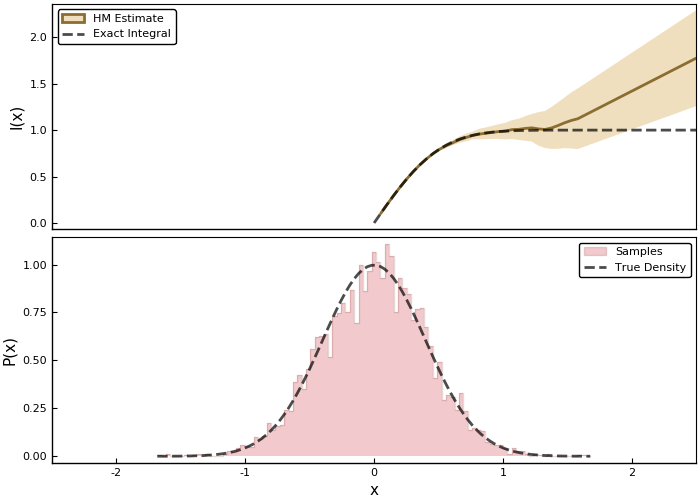

In [55]:
line_colors = ColorSchemes.tab20b

p1 = plot(hist, 
        seriestype = :steps, 
        linecolor=line_colors[13], 
        linealpha=0.2,
        fill=true, 
        fillcolor=line_colors[16],
        fillalpha=0.5, 
        label="Samples"
    )

p1 = plot!(bins, x->density_f(x), 
        linecolor=:black,
        linestyle=:dash,
        linealpha=0.7,
        lw=2, 
        label="True Density"
    )

p1 = plot!(grid=:false, 
        xlims=(-x_range[end], x_range[end]), 
        frame=true, 
        xlabel="x", 
        ylabel="P(x)"
    )

p2 = plot(x_range, hm_estimates, 
        lw=2, 
        linecolor=line_colors[9], 
        fillcolor=line_colors[12], 
        ribbon=hm_std,  
        fillalpha=0.6,  
        label="HM Estimate"
    )

p2 = plot!(x_range, cuba_integrals, 
        xlims=(-x_range[end], x_range[end]), 
        linestyle=:dash, 
        color=:black, 
        linealpha=0.7, 
        lw=2, 
        label="Exact Integral",
    )

p2 = plot!(legend=:topleft, 
        ylabel="I(x)",     
        grid=false, 
        frame=true, 
        xaxis=nothing,
    )

p3 = plot(p2, p1, layout = (2,1), size=(700,500))

## Harmonic Mean Calculation: 

# CUBA integral: 

cuba_integral = hcubature(density_f, [0.0], [10])

ahmi_integral = bat_integrate(samples).result .* Norm_prior

likelihood_val = exp.(samples.logd) * Norm_prior

V = 1 #maximum(samples_flat) - minimum(samples_flat)

@show I_hm = (sum(samples.weight * V)) /(sum(samples.weight ./ likelihood_val)) 
@show I_hm = (sum(samples.weight * Norm_prior)) /(sum(samples.weight ./ likelihood_val)) 

# Create Cubes: 

x1_min = -2
x1_max = -1
x2_min = 1
x2_max = 2

vspan([x1_min, x1_max, x2_min, x2_max], linecolor=:black, fillcolor=:gray, label="", linealpha=0.2, fillalpha=0.2)

plot!(hist, 
    seriestype = :steps, 
    linecolor=line_colors[13], 
    linealpha=0.2,
    fill=true, 
    fillcolor=line_colors[16],
    fillalpha=0.5, 
    label="",)

plot!(grid=:false, frame=true, xlabel="x", ylabel="P(x)")